# GPR
 * Implement log marginal likelihood optimization
 * Implement multiple kernels
     * linear
     * periodic
     * rational quadratic
 * Use HXDY to do log marginal likelihood optimization
#### Imports and Function Defs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import scipy.sparse.linalg

### Kernel Defs

In [2]:
#@nb.njit(cache=True)
def rbf(xp, xq, l, sf):
    return sf*sf*np.exp(-.5 * np.sum(np.power((xp-xq)/l, 2)))

### Kernel Derivative Defs

In [3]:
#@nb.njit(cache=True)
def rbf_prime(xp, xq, l, sf):
    x_diff = xp-xq # this is a vector
    result = np.empty(len(l)+1)
    
    l_power = sf*sf*np.exp(-.5 * np.sum(np.power(x_diff/l, 2)))
    for i in range(len(l)): result[i] =  l_power * x_diff[i] * x_diff[i] * np.power(l[i], -3)
        
    result[-1] = 2.*sf*np.exp(-.5 * np.sum(np.power(x_diff/l, 2)))
    
    return result

### Covariance Matrix Calculations

In [4]:
#@nb.njit(parallel=True)
def K_XX(X, l, sf):
    cov = np.empty((len(X),len(X)))
    for i in range(len(X)):
        for j in range(i+1):
            cov[i,j] = cov[j,i] = rbf(X[i], X[j], l, sf)
    return cov

In [5]:
#@nb.njit(parallel=True)
def K_XY(X, Y, l, sf):
    cov = np.empty((len(Y),len(X)))
    for i in range(len(Y)):
        for j in range(len(X)):
            cov[i,j] = rbf(Y[i], X[j], l, sf)
    return cov

### Prediction Tools

In [6]:
#@nb.njit(parallel=True)
def predict(X, X_s, l, sf, k_xx_i_y, y_mean):
    return np.dot(K_XY(X, X_s, l, sf), k_xx_i_y) + y_mean

In [7]:
def fitPredict(X_train, y_train, X_test, l, sf):

    k_xx = K_XX(X_train, l, sf)
    y_mean = np.mean(y_train)
    k_xx_i_y = scipy.sparse.linalg.minres(k_xx, y_train-y_mean)[0] 
    pred = predict(X_train, X_test, l, sf, k_xx_i_y, y_mean)
    
    return pred

### $\theta$ Optimization Tools

In [8]:
def log_marginal_likelihood(x, y, l, sf):
    K = K_XX(x, l, sf)
    K_inv = np.linalg.pinv(K)
    
    term1 = -.5*np.log(np.linalg.det(K))
    term2 = -.5*((y.T @ K_inv @ y)[0,0])
    term3 = -(len(x)/2)*np.log(2.*np.pi)
    return -(term1 + term2 + term3)

In [9]:
def log_marginal_likelihood_prime(x, y, l, sf):
    
    K = K_XX(x, l, sf)
    K_inv = np.linalg.pinv(K)

    alpha = y.T @ K_inv

    kernel_der = np.empty((len(x), len(x), len(l)+1))

    for i in range(len(x)):
        for j in range(len(x)):
            kernel_der[i,j] = rbf_prime(x[i], x[j], l, sf)
    
    #print(np.around(kernel_der[:,:,0], 2))
    
    der = np.empty(len(l) + 1)
    
    for i in range(len(der)):
        idx = tuple([slice(None)]*(kernel_der.ndim-1) + [i])
        #print(np.around(kernel_der[idx], 2))
        der[i] = (.5 * alpha @ kernel_der[idx] @ alpha.T)[0,0] 
        der[i] -= .5*np.trace(K_inv @ kernel_der[idx])
        #print((.5 * alpha @ kernel_der[idx] @ alpha.T)[0,0], -.5*np.trace(K_inv @ kernel_der[idx]))
    return -der

### Testing

In [10]:
x = np.arange(-np.pi, np.pi, 1e-2).reshape(-1,1)
y = (np.sin(x)**2).reshape(-1,1)

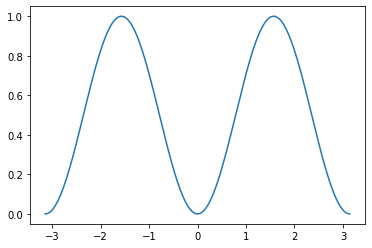

In [11]:
plt.plot(x, y);

In [12]:
l = .1*np.ones(1)
sf = 1.

In [13]:
p = fitPredict(x[::100], y[::100], x, l, sf)

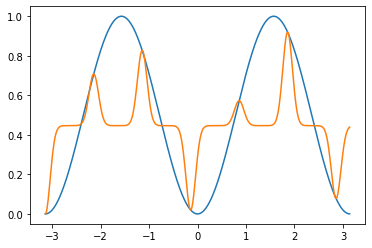

In [14]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');

In [15]:
l = 1.*np.ones(1)
sf = 1.

In [16]:
p = fitPredict(x[::100], y[::100], x, l, sf)

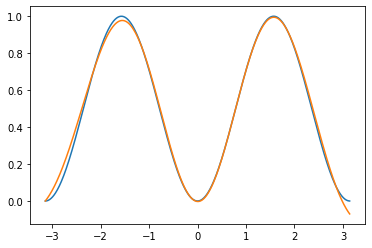

In [17]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');

In [18]:
l_range = np.arange(.1, 2, 1e-2)

In [19]:
sf = 1.

In [20]:
z = np.empty((len(l_range), 2))

In [21]:
for i in range(len(l_range)):
    z[i, 0] = log_marginal_likelihood_prime(x[::100], y[::100], np.array([l_range[i]]), sf)[0]
    z[i, 1] = log_marginal_likelihood(x[::100], y[::100], np.array([l_range[i]]), sf)

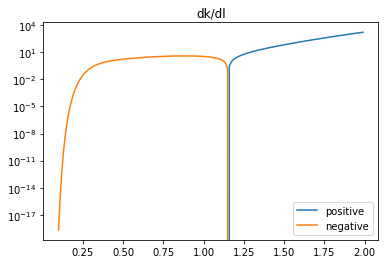

In [22]:
plt.plot(l_range, z[:,0], label='positive')
plt.plot(l_range, -z[:,0], label='negative')
plt.legend()
plt.title('dk/dl')
plt.yscale('log');

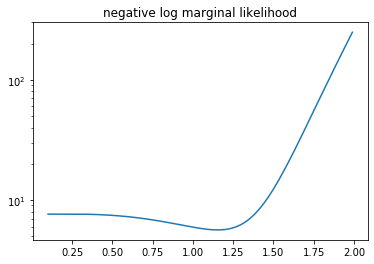

In [23]:
plt.plot(l_range, z[:,1])
plt.title('negative log marginal likelihood')
plt.yscale('log');

In [24]:
sf_range = np.arange(.1, 2, 1e-2)

In [25]:
l = np.array([1.24])

In [26]:
z = np.empty((len(sf_range), 2))

In [27]:
for i in range(len(l_range)):
    z[i, 0] = log_marginal_likelihood_prime(x[::100], y[::100], l, sf_range[i])[1]
    z[i, 1] = log_marginal_likelihood(x[::100], y[::100], l, sf_range[i])

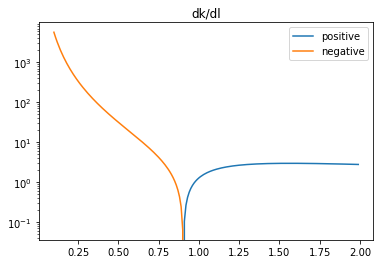

In [28]:
plt.plot(l_range, z[:,0], label='positive')
plt.plot(l_range, -z[:,0], label='negative')
plt.legend()
plt.title('dk/dl')
plt.yscale('log');

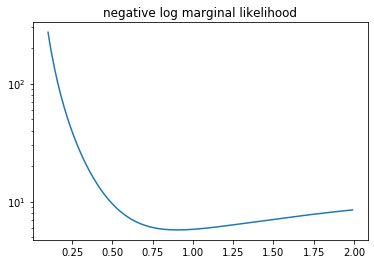

In [29]:
plt.plot(l_range, z[:,1])
plt.title('negative log marginal likelihood')
plt.yscale('log');

In [30]:
l = 1.24*np.ones(1)
sf = .75

In [31]:
p = fitPredict(x[::100], y[::100], x, l, sf)

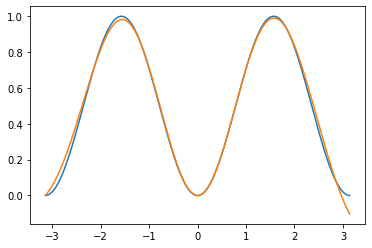

In [32]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');

In [33]:
import scipy.optimize

In [34]:
def func_wrapper(params, x, y):
    l = np.array([params[0]])
    sf = params[1]
    return log_marginal_likelihood(x, y, l, sf), log_marginal_likelihood_prime(x, y, l, sf)

In [35]:
best = scipy.optimize.minimize(func_wrapper, x0=(1.24, .75), args=(x[::50], y[::50]), jac=True, method='BFGS')
best

      fun: -20.09147582375495
 hess_inv: array([[0.0128055 , 0.07141242],
       [0.07141242, 0.52838479]])
      jac: array([ 6.81509231e-06, -5.07287840e-07])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([1.55507694, 1.86078941])

In [38]:
l = np.array([best.x[0]])
sf = best.x[1]

In [39]:
l, sf

(array([1.55507694]), 1.8607894142958048)

In [40]:
p = fitPredict(x[::100], y[::100], x, l, sf)

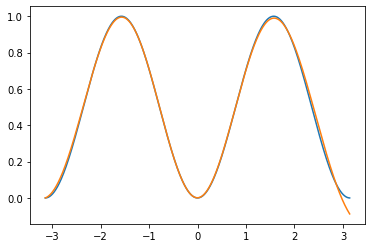

In [41]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');